In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install transformers

In [4]:
import json
import torch
import itertools
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import trange
from tqdm.notebook import tqdm
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import f1_score as f1
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
def check_for_gpu():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device

In [6]:
device = check_for_gpu()
device

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


device(type='cuda')

# Importing Train/Test sets

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/training_set_05_12.csv", 
                       usecols=["review_text", "genre"]).dropna().reset_index(drop=True)

In [ ]:
train_df.genre.value_counts()

Art                2000
Fiction            2000
Mystery            2000
NonFiction         2000
Romance            2000
Science Fiction    2000
Name: genre, dtype: int64

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/test_set_preprocessed.csv", 
                      usecols=["review_text", "genre"]).dropna().reset_index(drop=True)

In [ ]:
x_train = [row for row in train_df["review_text"]]
y_train = [row for row in train_df["genre"]]

x_test = [row for row in test_df["review_text"]]
y_test = [row for row in test_df["genre"]]

In [ ]:
len(x_train),len(y_train),len(x_test),len(y_test)

(12000, 12000, 373300, 373300)

In [ ]:
train_df.genre.value_counts()

Art                2000
Fiction            2000
Mystery            2000
NonFiction         2000
Romance            2000
Science Fiction    2000
Name: genre, dtype: int64

In [ ]:
test_df.genre.value_counts()

Fiction            213931
Romance             77884
Mystery             26909
NonFiction          24121
Science Fiction     17822
Art                 12633
Name: genre, dtype: int64

### Labelling y_train/y_test

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(y_train)
print(le.classes_)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

y_test

['Art' 'Fiction' 'Mystery' 'NonFiction' 'Romance' 'Science Fiction']


array([1, 1, 1, ..., 4, 1, 1])

# Transformer Inizialization

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# # Print the original sentence.
# print(' Original: \n', x_train[0],"\n")

# # Print the sentence split into tokens.
# print('Tokenized: \n', tokenizer.tokenize(x_train[0]),"\n")

# # Print the sentence mapped to token ids.
# print('Token IDs: \n', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(x_train[0])))

#### BERT Requirements:
- Add special tokens at the beginning and the end of each Tokenized text: `[CLS]` and `[SEP]`
- Set token lenght to a fixed amount
- Make artificial token explicit with the attention mask

In [ ]:
def ids_attention_masks(_input: list, MAX_LEN:int = 100) -> (list,list):
    
    """ Tokenizes text with '[CLS]' and '[SEP]' tokens and creates relatives masks """
    
    input_ids = []
    attention_masks = []
    
    for review in tqdm(_input):
        encoded_dict = tokenizer.encode_plus(
                            review,                        # Review to encode.
                            add_special_tokens = True,     # Add '[CLS]' and '[SEP]'
                            max_length = MAX_LEN,          # Pad & truncate all sentences.
                            pad_to_max_length = True,      # (padding = "max_length" dives error later on)
                            return_attention_mask = True,  # Construct attention masks.
                            return_tensors = 'pt')         # Return pytorch tensors.
            
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return input_ids, attention_masks

In [ ]:
def splitting_train_val_with_masks(ids_train: list, amasks_train: list, labels_train: list):

    """ Return splitted Train_set and Validation_set with relatives masks"""
    
    (train_inputs, validation_inputs,
     train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                         random_state=42,
                                                         test_size=0.20)
    (train_masks, validation_masks,
     _, _) = train_test_split(amasks_train, ids_train,
                              random_state=42, test_size=0.20)
     
    return train_inputs, train_labels, validation_inputs, validation_labels, train_masks, validation_masks

In [ ]:
def to_tensor(*args) -> tuple:
    """ Transforms multiple dim. lists and 1 dim. arrays to tensors """
    return tuple( torch.cat(el, dim=0) if type(el) == list else torch.tensor(el) for el in args  )

In [ ]:
input_ids_train, attention_masks_train = ids_attention_masks(x_train)

  0%|          | 0/12000 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
input_ids_test, attention_masks_test = ids_attention_masks(x_test)

  0%|          | 0/373300 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
len(input_ids_train), len(attention_masks_train), len(y_train)

(12000, 12000, 12000)

## Spitting Training to train/Validation

***Retrieving Validation Inputs, Masks and Labels***

In [ ]:
(train_inputs, 
train_labels, 
val_inputs, 
val_labels, 
train_masks, 
val_masks) = splitting_train_val_with_masks(input_ids_train, attention_masks_train, y_train)

***Converting lists to Tensors***

In [ ]:
# Convert the lists into tensors.
train_inputs, train_masks, train_labels = to_tensor(train_inputs, train_masks, train_labels)

validation_inputs, validation_masks, validation_labels = to_tensor(val_inputs, val_masks, val_labels)

test_inputs, test_masks, test_labels = to_tensor(input_ids_test, attention_masks_test, y_test)

In [ ]:
len(train_inputs), len(train_masks), len(train_labels)

(9600, 9600, 9600)

# Tensor Dataset

In [ ]:
#creating iterator od the dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) #CPU to GPU

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


print(f"Train_set: \t{len(train_data)} reviews \n" +
      f"Val_set: \t{len(validation_data)} reviews \n" +
      f"Test_data: \t{len(test_data)} reviews")

Train_set: 	9600 reviews 
Val_set: 	2400 reviews 
Test_data: 	373300 reviews


# BERT

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model_name = "bert-base-uncased"
bert_BU_model = BertForSequenceClassification.from_pretrained(model_name, num_labels= len(le.classes_))

# Make it run on GPU
bert_BU_model.cuda()

***Setting up Optimizer and Scheduler***

In [ ]:
def get_optimizer_scheduler(model, epochs: int, weight_decay: float, learning_rate: float):
    """ Returning optimizer and scheduler of the model for the current input Hyperparameters"""

    warmup_steps = int(0.2*len(train_dataloader))
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
                                    {'params': [tensor for parameter, tensor in model.named_parameters()
                                                if not any(el in parameter for el in no_decay)],
                                     'weight_decay': weight_decay},
                                    {'params': [tensor for parameter, tensor in model.named_parameters()
                                                if any(el in parameter for el in no_decay)],
                                     'weight_decay': 0.0}
                                    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr= learning_rate, eps= 1e-8, no_deprecation_warning=True)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps= warmup_steps,
                                     num_training_steps =len(train_dataloader)*epochs)
    return optimizer, scheduler

In [ ]:
def train(model, optimizer, scheduler, epochs, loss_vector=None, log_interval=200):
    # Set model to training mode
    model.train()

    total_train_loss = 0
    # Loop over each batch from the training set
    for step, batch in enumerate(train_dataloader):

        batch = tuple(t.to(device) for t in batch)         # Copy data to GPU if needed
        b_input_ids, b_input_mask, b_labels = batch        # Unpack the inputs from our dataloader
        optimizer.zero_grad()                              # Zero gradient buffers

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs[0]
        if loss_vector is not None: loss_vector.append(loss.item())
        # total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        scheduler.step()

        if step % log_interval == 0:
            print(f'Train Epoch: {epochs} [{step * len(b_input_ids)}/{len(train_dataloader.dataset)}' +
                  f'({100. * step / len(train_dataloader):.0f}%)]\tLoss: {loss:.6f}')
            
    # if loss_vector is not None: loss_vector.append(total_train_loss / len(train_dataloader))



def evaluate(model, loader, loss_vector=None):
    model.eval()
    n_correct, n_all = 0, 0
    predicted_labels, true_labels = list(), list()
    full_predictions, full_labels = np.array([]), np.array([])
    
    logits_res = []
    for batch in loader:
        
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        loss = outputs[0]
        if loss_vector is not None: loss_vector.append(loss.item())

        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        logits_res.append(logits)
        predictions = np.argmax(logits, axis=1)

        labels = b_labels.to('cpu').numpy()
        n_correct += np.sum(predictions == labels)

        true_labels.extend(labels)
        predicted_labels.extend(predictions)

        full_predictions = np.concatenate((full_predictions, predictions), axis=0)
        full_labels = np.concatenate((full_labels, labels), axis=0)
        n_all += len(labels)
    
    logits_res = [array for el in logits_res for array in el.tolist()]
    f1_score = f1(full_labels, full_predictions, average="macro")
    # print(f'F1 Score: {f1_score:.4f}')
    # print(f'Accuracy: [{n_correct}/{n_all}] {(n_correct/n_all):.4f}')
    # print('Classification report:')
    # print(classification_report(true_labels, predicted_labels))
    # print('Confusion matrix:')
    # cm = confusion_matrix(true_labels, predicted_labels)
    # print(cm)
    return f1_score, true_labels, predicted_labels, logits_res

# Tuning

In [ ]:
def hypter_param_selection(input_params: list, n_classes: int, validation_dataloader, model_name):
    
    """ 
    Hyper parameters tuning on Validation/Test set.
    Returns a dict of best params
    """
    
    epochs = 4
    params_list = input_params.keys()
    res = dict()
    
    #cartesian product of the params
    for param in itertools.product(*[param for param in input_params.values()]):
        current_params_dict = dict(zip(params_list, param))
        print(f"Hyperparameters --> {current_params_dict}")
        
        #initialize the model, retrieving Optimizer and Scheduler
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels = n_classes)   
        model.cuda()
        optimizer, scheduler = get_optimizer_scheduler(model, epochs, *current_params_dict.values())
        
        #training on validation
        f1_mean = float(0)
        for epoch in range(1, epochs + 1):
            train(model, optimizer, scheduler, epoch)
            f1_score, _, _, _  = evaluate(model, validation_dataloader)
            f1_mean += f1_score
        f1_mean /= epochs

        res.update({str(current_params_dict) : f1_mean})          
    return res

In [ ]:
param_grid = {
              'weight_decay': [0.01, 0.1, 0.001], 
              'lr': [2e-5, 3e-5, 4e-5]
             }

res = hypter_param_selection(param_grid, 10, validation_dataloader, model_name)

Hyperparameters --> {'weight_decay': 0.01, 'lr': 2e-05}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Train Epoch: 1 [0/9600(0%)]	Loss: 2.232619
Train Epoch: 1 [6400/9600(67%)]	Loss: 1.177053
Train Epoch: 2 [0/9600(0%)]	Loss: 1.087307
Train Epoch: 2 [6400/9600(67%)]	Loss: 0.695333
Train Epoch: 3 [0/9600(0%)]	Loss: 0.826209
Train Epoch: 3 [6400/9600(67%)]	Loss: 0.456161
Train Epoch: 4 [0/9600(0%)]	Loss: 0.598634
Train Epoch: 4 [6400/9600(67%)]	Loss: 0.302404
Hyperparameters --> {'weight_decay': 0.01, 'lr': 3e-05}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Train Epoch: 1 [0/9600(0%)]	Loss: 2.355973
Train Epoch: 1 [6400/9600(67%)]	Loss: 1.059198
Train Epoch: 2 [0/9600(0%)]	Loss: 0.722096
Train Epoch: 2 [6400/9600(67%)]	Loss: 0.547901
Train Epoch: 3 [0/9600(0%)]	Loss: 0.436388
Train Epoch: 3 [6400/9600(67%)]	Loss: 0.417493
Train Epoch: 4 [0/9600(0%)]	Loss: 0.304804
Train Epoch: 4 [6400/9600(67%)]	Loss: 0.303873
Hyperparameters --> {'weight_decay': 0.01, 'lr': 4e-05}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Train Epoch: 1 [0/9600(0%)]	Loss: 2.544617
Train Epoch: 1 [6400/9600(67%)]	Loss: 1.027846
Train Epoch: 2 [0/9600(0%)]	Loss: 1.053838
Train Epoch: 2 [6400/9600(67%)]	Loss: 0.889036
Train Epoch: 3 [0/9600(0%)]	Loss: 0.367705
Train Epoch: 3 [6400/9600(67%)]	Loss: 0.204132
Train Epoch: 4 [0/9600(0%)]	Loss: 0.464941
Train Epoch: 4 [6400/9600(67%)]	Loss: 0.077920
Hyperparameters --> {'weight_decay': 0.1, 'lr': 2e-05}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Train Epoch: 1 [0/9600(0%)]	Loss: 2.425396
Train Epoch: 1 [6400/9600(67%)]	Loss: 1.149930
Train Epoch: 2 [0/9600(0%)]	Loss: 1.186842
Train Epoch: 2 [6400/9600(67%)]	Loss: 0.917086
Train Epoch: 3 [0/9600(0%)]	Loss: 0.642818
Train Epoch: 3 [6400/9600(67%)]	Loss: 0.819371
Train Epoch: 4 [0/9600(0%)]	Loss: 0.340987
Train Epoch: 4 [6400/9600(67%)]	Loss: 0.648629
Hyperparameters --> {'weight_decay': 0.1, 'lr': 3e-05}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Train Epoch: 1 [0/9600(0%)]	Loss: 2.283876
Train Epoch: 1 [6400/9600(67%)]	Loss: 1.076296
Train Epoch: 2 [0/9600(0%)]	Loss: 0.729796
Train Epoch: 2 [6400/9600(67%)]	Loss: 0.584997
Train Epoch: 3 [0/9600(0%)]	Loss: 0.580153
Train Epoch: 3 [6400/9600(67%)]	Loss: 0.288256
Train Epoch: 4 [0/9600(0%)]	Loss: 0.250516
Train Epoch: 4 [6400/9600(67%)]	Loss: 0.603794
Hyperparameters --> {'weight_decay': 0.1, 'lr': 4e-05}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Train Epoch: 1 [0/9600(0%)]	Loss: 2.457422
Train Epoch: 1 [6400/9600(67%)]	Loss: 0.877852
Train Epoch: 2 [0/9600(0%)]	Loss: 0.726300
Train Epoch: 2 [6400/9600(67%)]	Loss: 0.657920
Train Epoch: 3 [0/9600(0%)]	Loss: 0.373791
Train Epoch: 3 [6400/9600(67%)]	Loss: 0.405170
Train Epoch: 4 [0/9600(0%)]	Loss: 0.414205
Train Epoch: 4 [6400/9600(67%)]	Loss: 0.348936
Hyperparameters --> {'weight_decay': 0.001, 'lr': 2e-05}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Train Epoch: 1 [0/9600(0%)]	Loss: 2.435024
Train Epoch: 1 [6400/9600(67%)]	Loss: 1.238826
Train Epoch: 2 [0/9600(0%)]	Loss: 1.015798
Train Epoch: 2 [6400/9600(67%)]	Loss: 0.826245
Train Epoch: 3 [0/9600(0%)]	Loss: 0.526537
Train Epoch: 3 [6400/9600(67%)]	Loss: 0.573387
Train Epoch: 4 [0/9600(0%)]	Loss: 0.513496
Train Epoch: 4 [6400/9600(67%)]	Loss: 0.263481
Hyperparameters --> {'weight_decay': 0.001, 'lr': 3e-05}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Train Epoch: 1 [0/9600(0%)]	Loss: 2.318721
Train Epoch: 1 [6400/9600(67%)]	Loss: 1.090254
Train Epoch: 2 [0/9600(0%)]	Loss: 0.891193
Train Epoch: 2 [6400/9600(67%)]	Loss: 0.677954
Train Epoch: 3 [0/9600(0%)]	Loss: 0.489326
Train Epoch: 3 [6400/9600(67%)]	Loss: 0.653357
Train Epoch: 4 [0/9600(0%)]	Loss: 0.319318
Train Epoch: 4 [6400/9600(67%)]	Loss: 0.143199
Hyperparameters --> {'weight_decay': 0.001, 'lr': 4e-05}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Train Epoch: 1 [0/9600(0%)]	Loss: 2.362069
Train Epoch: 1 [6400/9600(67%)]	Loss: 1.168229
Train Epoch: 2 [0/9600(0%)]	Loss: 1.069485
Train Epoch: 2 [6400/9600(67%)]	Loss: 0.894516
Train Epoch: 3 [0/9600(0%)]	Loss: 0.334540
Train Epoch: 3 [6400/9600(67%)]	Loss: 0.417141
Train Epoch: 4 [0/9600(0%)]	Loss: 0.084332
Train Epoch: 4 [6400/9600(67%)]	Loss: 0.185453


In [ ]:
res

{"{'weight_decay': 0.01, 'lr': 2e-05}": 0.6699045175009564,
 "{'weight_decay': 0.01, 'lr': 3e-05}": 0.6759502158421645,
 "{'weight_decay': 0.01, 'lr': 4e-05}": 0.67737765261448,
 "{'weight_decay': 0.1, 'lr': 2e-05}": 0.6704321267648828,
 "{'weight_decay': 0.1, 'lr': 3e-05}": 0.6756271467629933,
 "{'weight_decay': 0.1, 'lr': 4e-05}": 0.6624165687540219,
 "{'weight_decay': 0.001, 'lr': 2e-05}": 0.6692461138570338,
 "{'weight_decay': 0.001, 'lr': 3e-05}": 0.6769361258048985,
 "{'weight_decay': 0.001, 'lr': 4e-05}": 0.6738437604599368}

In [ ]:
# retrieving a dictionary of best params, adding 3 epochs as last
import ast

best_parameters_str = max(res, key=res.get)
best_params = ast.literal_eval("{" + "'epoch': 3, " + best_parameters_str[1:])

best_params

{'epoch': 3, 'weight_decay': 0.01, 'lr': 4e-05}

In [ ]:
bert_BU_model = BertForSequenceClassification.from_pretrained(model_name, num_labels= len(le.classes_))   
bert_BU_model.cuda()
optimizer, scheduler= get_optimizer_scheduler(bert_BU_model, *best_params.values())

#evaluating on test
train_lossv = list()
for epoch in range(1, best_params["epoch"] + 1):
    print()
    train(bert_BU_model, optimizer, scheduler, epoch, train_lossv)
    f1_score, _, _, _ = evaluate(bert_BU_model, test_dataloader)   #true_labels, predicted_labels, logits

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Train Epoch: 1 [0/9600(0%)]	Loss: 1.734190
Train Epoch: 1 [6400/9600(67%)]	Loss: 1.061995

Train Epoch: 2 [0/9600(0%)]	Loss: 0.770429
Train Epoch: 2 [6400/9600(67%)]	Loss: 0.790559

Train Epoch: 3 [0/9600(0%)]	Loss: 0.429820
Train Epoch: 3 [6400/9600(67%)]	Loss: 0.314664


In [ ]:
f1_score_train, _, _, _ = evaluate(bert_BU_model, train_dataloader)
f1_score_train

0.9291664500031699

In [ ]:
f1_score_test, true_labels, predicted_labels, logits = evaluate(bert_BU_model, test_dataloader)
f1_score_test

0.4847160975625509

In [ ]:
len(logits), len(true_labels), len(predicted_labels)

(373300, 373300, 373300)

In [ ]:
print('Classification report:')
print(classification_report(true_labels, predicted_labels))
print('Confusion matrix:')
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.47      0.71      0.57     12633
           1       0.81      0.44      0.57    213931
           2       0.29      0.57      0.39     26909
           3       0.29      0.65      0.40     24121
           4       0.55      0.65      0.60     77884
           5       0.28      0.62      0.38     17822

    accuracy                           0.53    373300
   macro avg       0.45      0.61      0.48    373300
weighted avg       0.65      0.53      0.54    373300

Confusion matrix:
[[ 9009   862   611   801   727   623]
 [ 7397 95020 26789 27793 34349 22583]
 [  721  3740 15261  2782  2763  1642]
 [  446  3174  1715 15743  1915  1128]
 [ 1219 11857  6395  5447 50442  2524]
 [  453  2560  1315  1417  1093 10984]]


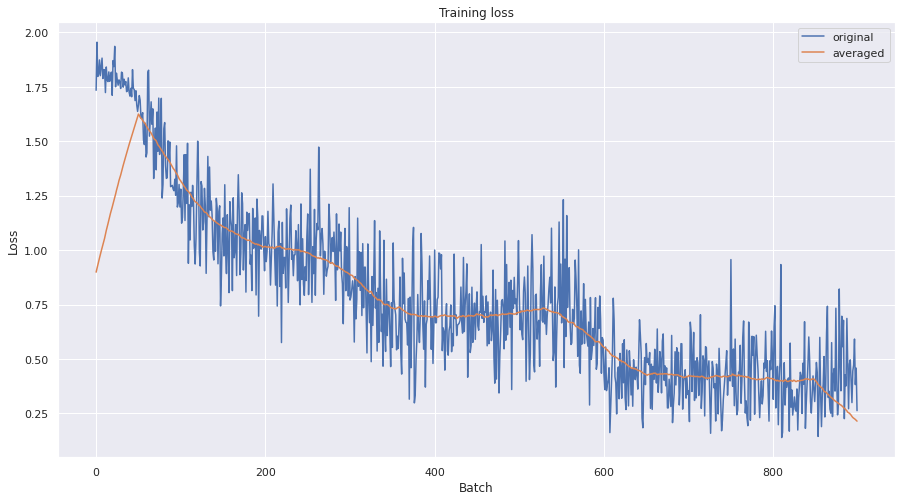

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()